In [1]:
import os, sys
sys.path.append("..")
sys.path.append("../ALAE")

import torch
import numpy as np

from src.light_sb_ou import LightSB_OU
from src.distributions import LoaderSampler, TensorSampler
import deeplake
from tqdm import tqdm

from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from alae_ffhq_inference import load_model, encode, decode

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from PIL import Image
import os

## Config

In [2]:
DIM = 512
assert DIM > 1

INPUT_DATA = "MAN" # MAN, WOMAN, ADULT, CHILDREN
TARGET_DATA = "WOMAN" # MAN, WOMAN, ADULT, CHILDREN

OUTPUT_SEED = 0xBADBEEF
BATCH_SIZE = 128
EPSILON = 0.1
D_LR = 1e-3 
D_GRADIENT_MAX_NORM = float("inf")
N_POTENTIALS = 10
SAMPLING_BATCH_SIZE = 128
INIT_BY_SAMPLES = True
IS_DIAGONAL = True

MAX_STEPS = 10000
CONTINUE = -1

# Data loading

### TO DOWNLOAD PRE-PROCESSED ALAE DATA, UNCOMMENT THE CODE OF THE NEXT CELL.

In [3]:
'''
import gdown
import os

urls = {
    "../data/age.npy": "https://drive.google.com/uc?id=1Vi6NzxCsS23GBNq48E-97Z9UuIuNaxPJ",
    "../data/gender.npy": "https://drive.google.com/uc?id=1SEdsmQGL3mOok1CPTBEfc_O1750fGRtf",
    "../data/latents.npy": "https://drive.google.com/uc?id=1ENhiTRsHtSjIjoRu1xYprcpNd8M9aVu8",
    "../data/test_images.npy": "https://drive.google.com/uc?id=1SjBWWlPjq-dxX4kxzW-Zn3iUR3po8Z0i",
}

for name, url in urls.items():
    gdown.download(url, os.path.join(f"{name}"), quiet=False)
'''

'\nimport gdown\nimport os\n\nurls = {\n    "../data/age.npy": "https://drive.google.com/uc?id=1Vi6NzxCsS23GBNq48E-97Z9UuIuNaxPJ",\n    "../data/gender.npy": "https://drive.google.com/uc?id=1SEdsmQGL3mOok1CPTBEfc_O1750fGRtf",\n    "../data/latents.npy": "https://drive.google.com/uc?id=1ENhiTRsHtSjIjoRu1xYprcpNd8M9aVu8",\n    "../data/test_images.npy": "https://drive.google.com/uc?id=1SjBWWlPjq-dxX4kxzW-Zn3iUR3po8Z0i",\n}\n\nfor name, url in urls.items():\n    gdown.download(url, os.path.join(f"{name}"), quiet=False)\n'

In [4]:
# To download data use

train_size = 60000
test_size = 10000

latents = np.load("../data/latents.npy")
gender = np.load("../data/gender.npy")
age = np.load("../data/age.npy")
test_inp_images = np.load("../data/test_images.npy")

train_latents, test_latents = latents[:train_size], latents[train_size:]
train_gender, test_gender = gender[:train_size], gender[train_size:]
train_age, test_age = age[:train_size], age[train_size:]

if INPUT_DATA == "MAN":
    x_inds_train = np.arange(train_size)[(train_gender == "male").reshape(-1)]
    x_inds_test = np.arange(test_size)[(test_gender == "male").reshape(-1)]
elif INPUT_DATA == "WOMAN":
    x_inds_train = np.arange(train_size)[(train_gender == "female").reshape(-1)]
    x_inds_test = np.arange(test_size)[(test_gender == "female").reshape(-1)]
elif INPUT_DATA == "ADULT":
    x_inds_train = np.arange(train_size)[
        (train_age >= 18).reshape(-1)*(train_age != -1).reshape(-1)
    ]
    x_inds_test = np.arange(test_size)[
        (test_age >= 18).reshape(-1)*(test_age != -1).reshape(-1)
    ]
elif INPUT_DATA == "CHILDREN":
    x_inds_train = np.arange(train_size)[
        (train_age < 18).reshape(-1)*(train_age != -1).reshape(-1)
    ]
    x_inds_test = np.arange(test_size)[
        (test_age < 18).reshape(-1)*(test_age != -1).reshape(-1)
    ]
x_data_train = train_latents[x_inds_train]
x_data_test = test_latents[x_inds_test]

if TARGET_DATA == "MAN":
    y_inds_train = np.arange(train_size)[(train_gender == "male").reshape(-1)]
    y_inds_test = np.arange(test_size)[(test_gender == "male").reshape(-1)]
elif TARGET_DATA == "WOMAN":
    y_inds_train = np.arange(train_size)[(train_gender == "female").reshape(-1)]
    y_inds_test = np.arange(test_size)[(test_gender == "female").reshape(-1)]
elif TARGET_DATA == "ADULT":
    y_inds_train = np.arange(train_size)[
        (train_age >= 18).reshape(-1)*(train_age != -1).reshape(-1)
    ]
    y_inds_test = np.arange(test_size)[
        (test_age >= 18).reshape(-1)*(test_age != -1).reshape(-1)
    ]
elif TARGET_DATA == "CHILDREN":
    y_inds_train = np.arange(train_size)[
        (train_age < 18).reshape(-1)*(train_age != -1).reshape(-1)
    ]
    y_inds_test = np.arange(test_size)[
        (test_age < 18).reshape(-1)*(test_age != -1).reshape(-1)
    ]
y_data_train = train_latents[y_inds_train]
y_data_test = test_latents[y_inds_test]

X_train = torch.tensor(x_data_train)
Y_train = torch.tensor(y_data_train)

X_test = torch.tensor(x_data_test)
Y_test = torch.tensor(y_data_test)

X_sampler = TensorSampler(X_train, device="cpu")
Y_sampler = TensorSampler(Y_train, device="cpu")

# Model initialisation

## LightSB

In [5]:
torch.manual_seed(OUTPUT_SEED); np.random.seed(OUTPUT_SEED)

X_sampler = TensorSampler(X_train, device="cpu")
Y_sampler = TensorSampler(Y_train, device="cpu")

D = LightSB_OU(
    dim=DIM, 
    n_potentials=N_POTENTIALS, 
    epsilon=EPSILON, 
    b=0.001, 
    m=-1.0,
    sampling_batch_size=SAMPLING_BATCH_SIZE, 
    S_diagonal_init=0.1,
    is_diagonal=IS_DIAGONAL
).cpu()

if INIT_BY_SAMPLES:
    D.init_r_by_samples(Y_sampler.sample(N_POTENTIALS))
        
D_opt = torch.optim.Adam(D.parameters(), lr=D_LR)
        
for step in tqdm(range(CONTINUE + 1, MAX_STEPS)):
    D_opt.zero_grad()
                    
    X0, X1 = X_sampler.sample(BATCH_SIZE), Y_sampler.sample(BATCH_SIZE)
                    
    log_potential = D.get_log_potential(X1)
    log_C = D.get_log_C(X0)
                    
    D_loss = (-log_potential + log_C).mean()
    D_loss.backward()
    D_gradient_norm = torch.nn.utils.clip_grad_norm_(D.parameters(), max_norm=D_GRADIENT_MAX_NORM)
    D_opt.step()

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:53<00:00, 87.85it/s]


## ALAE

In [6]:
# To download the required model run, run training_artifacts/download_all.py in the ALAE folder.

model = load_model("../ALAE/configs/ffhq.yaml", training_artifacts_dir="../ALAE/training_artifacts/ffhq/")

# Results plotting

In [7]:
from IPython.display import clear_output

%matplotlib inline 

In [8]:
torch.manual_seed(OUTPUT_SEED); np.random.seed(OUTPUT_SEED)

inds_to_map = np.random.choice(np.arange((x_inds_test < 300).sum()), size=10, replace=False)
number_of_samples = 3

mapped_all = []
latent_to_map = torch.tensor(test_latents[x_inds_test[inds_to_map]])

inp_images = test_inp_images[x_inds_test[inds_to_map]]

with torch.no_grad():
    for k in range(number_of_samples):
        mapped = D(latent_to_map.cpu())
        mapped_all.append(mapped)
    
mapped = torch.stack(mapped_all, dim=1)

decoded_all = []
with torch.no_grad():
    for k in range(number_of_samples):
        decoded_img = decode(model, mapped[:, k])
        denom = (decoded_img.max() - decoded_img.min()) / 2
        decoded_img = ((decoded_img / denom + 0.5) * 255).type(torch.long).clamp(0, 255).cpu().type(torch.uint8).permute(0, 2, 3, 1).numpy()
        decoded_all.append(decoded_img)
        
decoded_all = np.stack(decoded_all, axis=1)

In [9]:
decoded_img = decode(model, mapped[:, 0])

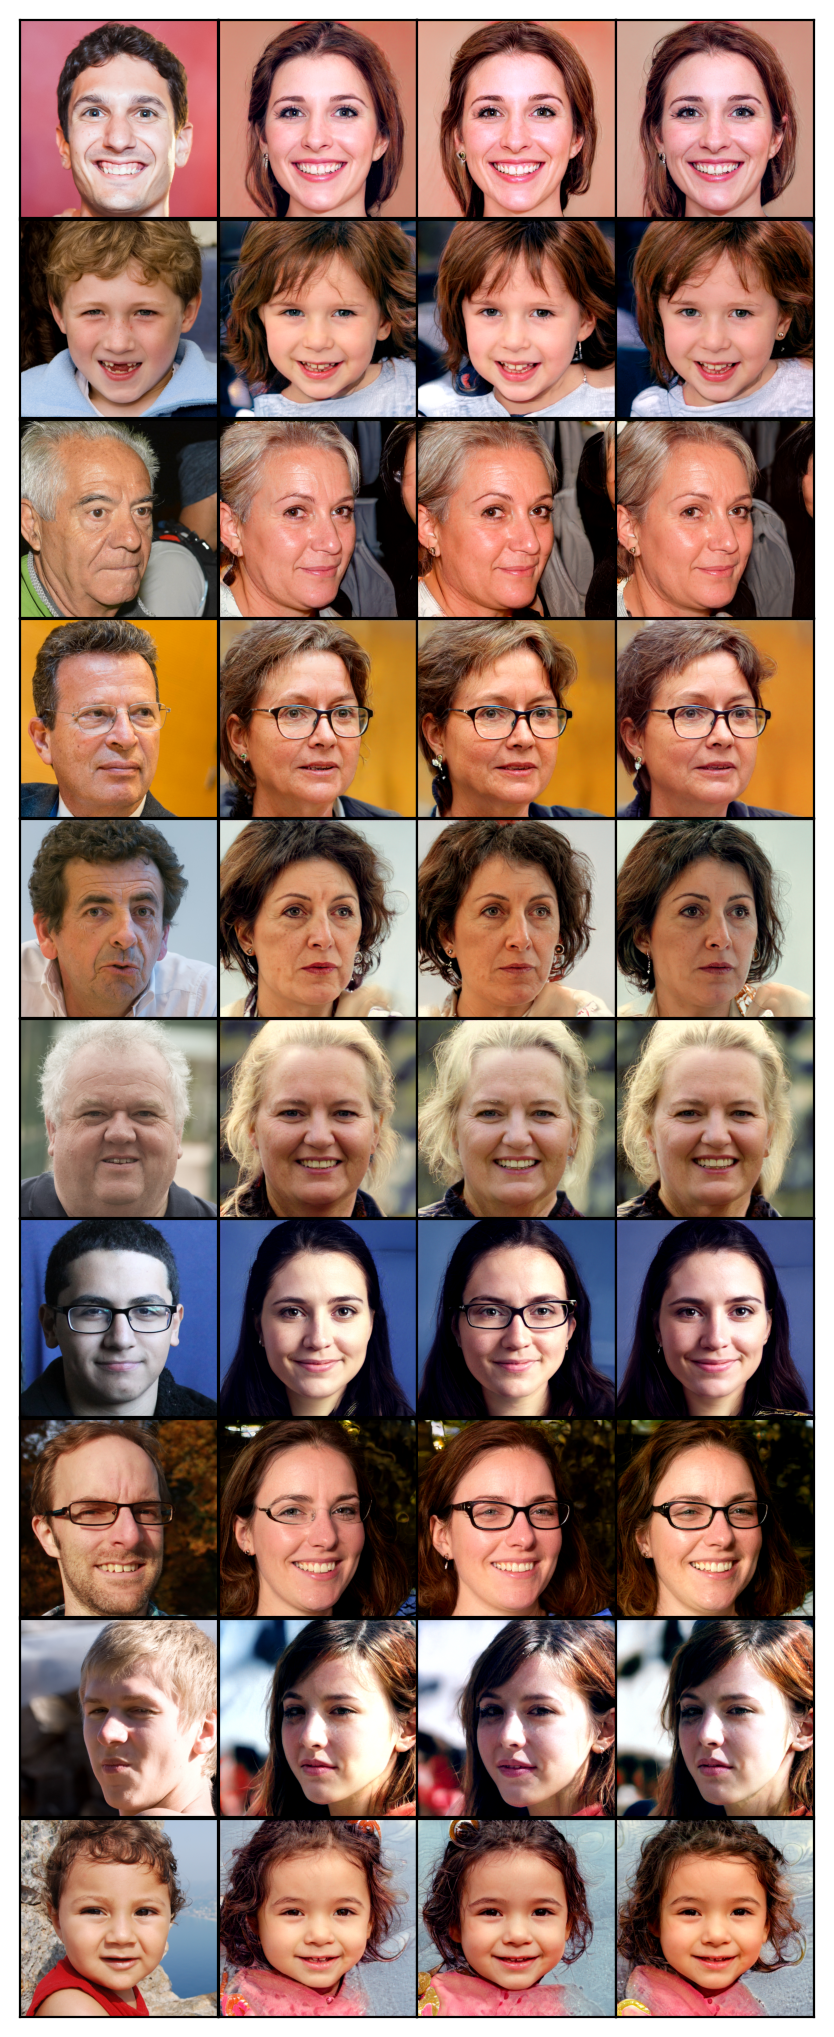

In [10]:
fig, axes = plt.subplots(10, number_of_samples+1, figsize=(number_of_samples+1, 10), dpi=200)

for i, ind in enumerate(range(10)):
    ax = axes[i]
    ax[0].imshow(inp_images[ind])
    for k in range(number_of_samples):
        ax[k+1].imshow(decoded_all[ind, k])
        
        ax[k+1].get_xaxis().set_visible(False)
        ax[k+1].set_yticks([])
        
    ax[0].get_xaxis().set_visible(False)
    ax[0].set_yticks([])

fig.tight_layout(pad=0.05)

In [11]:
output_dir = "face_comparisons"
os.makedirs(output_dir, exist_ok=True)

num_faces = 100
inds_to_map = np.random.choice(np.arange((x_inds_test < 300).sum()), size=num_faces, replace=False)
number_of_samples = 3

latent_to_map = torch.tensor(test_latents[x_inds_test[inds_to_map]])
inp_images = test_inp_images[x_inds_test[inds_to_map]]

with torch.no_grad():
    mapped_all = []
    for k in range(number_of_samples):
        mapped = D(latent_to_map.cpu())
        mapped_all.append(mapped)
    
    mapped = torch.stack(mapped_all, dim=1)
    
    decoded_all = []
    for k in range(number_of_samples):
        decoded_img = decode(model, mapped[:, k])
        decoded_img = ((decoded_img * 0.5 + 0.5) * 255).type(torch.long).clamp(0, 255).cpu().type(torch.uint8).permute(0, 2, 3, 1).numpy()
        decoded_all.append(decoded_img)
    
    decoded_all = np.stack(decoded_all, axis=1)

    for i in range(num_faces):
        original_img = (inp_images[i]).astype(np.uint8)
        
        combined = [original_img]
        for k in range(number_of_samples):
            combined.append(decoded_all[i, k])
        
        combined_img = np.concatenate(combined, axis=1)
        
        img = Image.fromarray(combined_img)
        img.save(os.path.join(output_dir, f"face_comparison_{i:03d}.png"), dpi=(300, 300))
        
        print(f"Saved comparison for face {i}")

print(f"All {num_faces} face comparisons saved to {output_dir}")

Saved comparison for face 0
Saved comparison for face 1
Saved comparison for face 2
Saved comparison for face 3
Saved comparison for face 4
Saved comparison for face 5
Saved comparison for face 6
Saved comparison for face 7
Saved comparison for face 8
Saved comparison for face 9
Saved comparison for face 10
Saved comparison for face 11
Saved comparison for face 12
Saved comparison for face 13
Saved comparison for face 14
Saved comparison for face 15
Saved comparison for face 16
Saved comparison for face 17
Saved comparison for face 18
Saved comparison for face 19
Saved comparison for face 20
Saved comparison for face 21
Saved comparison for face 22
Saved comparison for face 23
Saved comparison for face 24
Saved comparison for face 25
Saved comparison for face 26
Saved comparison for face 27
Saved comparison for face 28
Saved comparison for face 29
Saved comparison for face 30
Saved comparison for face 31
Saved comparison for face 32
Saved comparison for face 33
Saved comparison for fac